In [258]:
#packages
import numpy as np
import scipy.linalg as la
import networkx as nx 
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pickle


mpl.rc('font', size=10)
mpl.rc('legend', fontsize=10) 
mpl.rc('legend', numpoints=1)
mpl.rc('legend', handlelength=1)
mpl.rc('legend', frameon=False)
#mpl.rc('xtick.major', pad=7)
#mpl.rc('xtick.minor', pad=7)
mpl.rc('lines', lw=1)
mpl.rc('xtick',labelsize =8) 
mpl.rc('ytick',labelsize =8)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Complete Graph Hamiltonian

In [3]:

def H_CG(N, gamma, w, kappa):
    """
    Generate the Hamiltonian for search on the Complete Graph with a sink at target site.
    
    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: The resulting Hamiltonian in matrix form.
    """
    ket_s = np.ones((N, 1)) / np.sqrt(N) # Initial state (uniform superposition)
    H = -gamma * N * ket_s @ ket_s.T.conj() # Hamiltonian matrix of complete graph
    H = H.astype(complex)
    H[w, w] -= (1 + 1j * kappa)  # Target site
    return H.astype(complex)

## Eigenvalues and eigenvectors (theoretically)

In [5]:


def lambda_pm(N,gamma,kappa):

    """
    Compute the analytical expresion of the eigenvalues in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambda_plus (float): Eigenenergy of the form a + b
        lambda_minus (float): Eigenenergy of the form a - b
    """
    

    lambda_plus  = -(gamma*N + 1 + 1.0j*kappa)/2  + np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))
    lambda_minus = -(gamma*N + 1 + 1.0j*kappa)/2  - np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))

    return lambda_plus,lambda_minus

def imag_lambda_pm(N,gamma,kappa):

    """
    Compute the analytical expresion of the imaginary part of the eigenvalues in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        imag_lambda_plus (float): Imaginary part of eigenvalue lambda_plus
        imag_lambda_minus (float): Imaginary part of eigenvalue lambda_minus
    """
    
   # a  = ((gamma*N + 1)**2 - kappa**2)/4 - (gamma*N - gamma)
    a = 1/4 + gamma - N*gamma/2 + N*N*gamma*gamma/4 - kappa*kappa/4
    b  = kappa/2 + gamma*kappa - N*gamma*kappa/2
    mod_z = (1/4)*np.sqrt(4*(kappa*kappa)*(-1 + (N-2)*gamma)**2 + (-1 +2*(N - 2)*gamma - N*N*gamma*gamma + kappa*kappa)**2)
    #mod_z = np.sqrt(a**2 + b**2)

    imag_lambda_plus = - kappa/2 + np.sign(b)*np.sqrt((mod_z - a)/2)
    imag_lambda_minus = - kappa/2 - np.sign(b)*np.sqrt((mod_z - a)/2)

    return imag_lambda_plus, imag_lambda_minus

def lambdaR(N,gamma,kappa):

    """
    Compute the analytical expresion of the right eigenvectors in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambdaR_plus (np.ndarray): Right eigenvector corresponding to eigenvalue lambda_plus (column vector)
        lambdaR_minus (np.ndarray): Right eigenvector corresponding to eigenvalue lambda_minus (column vector)
    """   

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- lambda_plus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaR_plus = np.array([a_plus,b_plus])

    a_minus = (- lambda_minus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaR_minus = np.array([a_minus,b_minus])

    return lambdaR_plus, lambdaR_minus


def lambdaL(N,gamma,kappa):

    """
    Compute the analytical expresion of the left eigenvectors in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambdaL_plus (np.ndarray): Left eigenvector corresponding to eigenvalue lambda_plus (column vector)
        lambdaL_minus (np.ndarray): Left eigenvector corresponding to eigenvalue lambda_minus (column vector)
    """  

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- np.conj(lambda_plus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaL_plus = np.array([a_plus,b_plus])

    a_minus = (- np.conj(lambda_minus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaL_minus = np.array([a_minus,b_minus])

    return lambdaL_plus, lambdaL_minus



## Overlaps

In [6]:
def overlap(N,gamma,kappa):

    """
    Compute the analytical expresion of the overlaps with initial uniform superposition state. The overlaps corresponds to each term
    in the analytical expression of survival probability (see text for more details). 

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        overlap_plus (float): Overlap correspond to the decay rate governed by Im[lambda_plus].
        overlap_minus (float): Overlap correspond to the decay rate governed by Im[lambda_minus].
        overlap_pm (complex): Overlap correspond to the term having cross terms from both eigenvalues.
    """  

    lambdaR_plus, lambdaR_minus = lambdaR(N,gamma,kappa)
    lambdaL_plus, lambdaL_minus = lambdaL(N,gamma,kappa)

    #initial state
    ket_s = np.array([1.0/np.sqrt(N) ,np.sqrt((N-1)/N)])

    overlap_plus =(1/np.abs(np.vdot(lambdaL_plus,lambdaR_plus))**2)*np.vdot(lambdaR_plus,lambdaR_plus)*np.abs(np.vdot(ket_s, lambdaL_plus))**2

    overlap_minus =(1/np.abs(np.vdot(lambdaL_minus,lambdaR_minus))**2)*np.vdot(lambdaR_minus,lambdaR_minus)*np.abs(np.vdot(ket_s, lambdaL_minus))**2

    #overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)
    #overlap_mp = (1/(np.vdot(lambdaR_minus,lambdaL_minus)*np.vdot(lambdaL_plus,lambdaR_plus)))*np.vdot(ket_s,lambdaL_minus)*np.vdot(lambdaL_plus,ket_s)*np.vdot(lambdaR_minus, lambdaR_plus)
    overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)

    return overlap_plus, overlap_minus,overlap_pm

## Survival Probability theory without reset

In [9]:
def surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa):

    """
    Compute the survival probability as a function of time analytically in two-dimensional basis without any reset.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
 
    m = int(Tcutoff / dt)  # Number of time steps, each with duration dt

    #eigenvalues
    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    #overlaps 
    overlap_plus, overlap_minus,overlap_pm = overlap(N,gamma,kappa)
   
    s_prob = np.zeros(m) # Initialize array

    for j in range(m): 
        first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*j*dt)*overlap_plus
        second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*j*dt)*overlap_minus
        third_term  = 2*np.real(np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*j*dt)*overlap_pm)

        s_prob[j] = first_term + second_term +third_term


    return s_prob

## Find decay time in the survival probability 

In [8]:
def find_transition_point(arr, dt,tp): 
    """
    Find the first time index where the survival probability (SP) drops below tp.
    
    Args:
        arr (numpy array): Array of survival probability values.
        dt (float): Discretization of time into time steps of duration dt.
        
    Returns:
        float: Time at which SP drops below the value of tp.
    """
    idx = np.where(arr <= tp)[0]
    return idx[0] * dt if len(idx) > 0 else 0  # Return first occurrence or 0

## Decay time to 0.5

In [323]:
# Parameters
Tcutoff = 1000
dt = 0.05
kappa_vals = np.linspace(0.01, 0.4, 100)
N = 1000  # System size
gamma_vals = np.linspace(0.8/N, 1.2/N, 100)

# Storage Arrays
T_decay0p5_theory_single4 = np.zeros((len(gamma_vals), len(kappa_vals)))
s_prob_arr_theory = np.zeros((len(gamma_vals), len(kappa_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    for kk, kappa in enumerate(kappa_vals):
        s_prob_theory = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
        s_prob_arr_theory[gg, kk] = s_prob_theory
        T_decay0p5_theory_single4[gg, kk] = find_transition_point(s_prob_theory, dt,0.5)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3341753/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [11:32<00:00,  6.93s/it]


In [324]:
# These are the data points which cannot decay to the value of 0.5 for the 
T_decay0p5_theory_single4 = np.where(T_decay0p5_theory_single4==0, 1000, T_decay0p5_theory_single4)

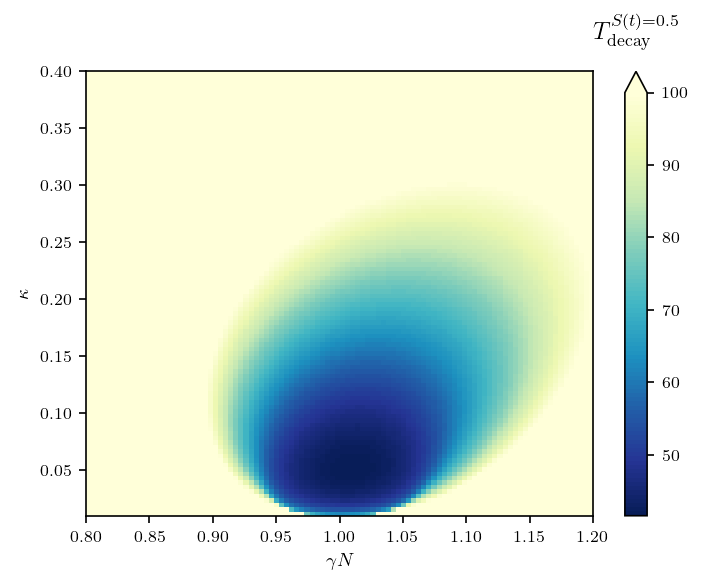

In [340]:
# Visualization - Minimum search time heatmap & Optimal reset rate heatmap
kappa_vals = np.linspace(0.01, 0.4, 100)
gamma_vals = np.linspace(0.8/N, 1.2/N, 100)
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
im1 = ax1.imshow(T_decay0p5_theory_single4.T, origin='lower', aspect='auto',
                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N,kappa_vals[0], kappa_vals[-1]],
                 cmap=plt.get_cmap('YlGnBu_r',100), vmax=100)
ax1.set_ylabel(r"$\kappa$")
ax1.set_xlabel(r"$\gamma N$")
cbar = fig.colorbar(im1, ax=ax1, extend = "max")
cbar.ax.set_title(r'$T_{\rm decay}^{S(t) = 0.5}$', size = 12,pad = 15)
plt.tight_layout()

#plt.savefig('../Figures/Final/decay_time_sprob.pdf', bbox_inches ='tight', transparent = True, dpi = 800)
plt.show()

In [326]:
filename = f"../Data/Data_Log/supplementary_survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_theory.pkl"
dict_to_save = [gamma_vals, kappa_vals,T_decay0p5_theory_single4]
with open(filename, 'wb') as f:
    pickle.dump(dict_to_save, f)

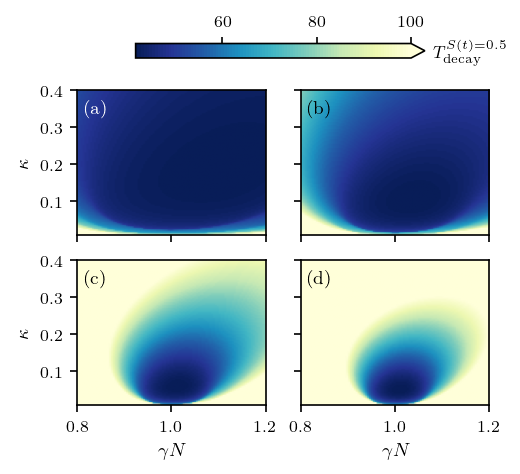

In [372]:
# --- Data & common settings ---
# kappa_vals: shape (Ny,), gamma_vals: shape (Nx,), N: scalar
# T_decay0p5_theory_single1..4: each shape (Ny, Nx)

extent = [gamma_vals[0]*N, gamma_vals[-1]*N, kappa_vals[0], kappa_vals[-1]]
cmap = plt.get_cmap('YlGnBu_r', 100)
vmax = 100  # keep consistent scaling across panels (set vmin if desired)

fig, axes = plt.subplots(2, 2, figsize=(3.40457,0.9*3.40457), constrained_layout=True, sharex=True, sharey=True)
ax11, ax12 = axes[0, 0], axes[0, 1]
ax21, ax22 = axes[1, 0], axes[1, 1]

# --- Panel (a) ---
im1 = ax11.imshow(T_decay0p5_theory_single1.T, origin='lower', aspect='auto',
                  extent=extent, cmap=cmap, vmax=vmax)
ax11.set_ylabel(r"$\kappa$")
ax11.set_title("(a)", x = 0.1, y = 0.75, color ='white')

# --- Panel (b) ---
im2 = ax12.imshow(T_decay0p5_theory_single2.T, origin='lower', aspect='auto',
                  extent=extent, cmap=cmap, vmax=vmax)
ax12.set_title("(b)", x = 0.1, y = 0.75)
# ax12.set_xlabel(r"$\gamma N$")  # usually omit on top row

# --- Panel (c) ---
im3 = ax21.imshow(T_decay0p5_theory_single3.T, origin='lower', aspect='auto',
                  extent=extent, cmap=cmap, vmax=vmax)
ax21.set_ylabel(r"$\kappa$")
ax21.set_title("(c)",x = 0.1, y = 0.75)
ax21.set_xlabel(r"$\gamma N$")

# --- Panel (d) ---
im4 = ax22.imshow(T_decay0p5_theory_single4.T, origin='lower', aspect='auto',
                  extent=extent, cmap=cmap, vmax=vmax)
ax22.set_title("(d)",x = 0.1, y = 0.75)
ax22.set_xlabel(r"$\gamma N$")

# --- Shared horizontal colorbar at top ---
cbar = fig.colorbar(im4, ax=[ax11, ax12, ax21, ax22], extend = 'max', location="top", pad=0.06, fraction=0.046)
# Put the colorbar title on the right edge of the bar

cbar.ax.text(1.08, -0.5, r"$T_{\rm decay}^{S(t)=0.5}$",
             transform=cbar.ax.transAxes, ha="left", va="bottom",fontsize = 8)

plt.savefig('supplementary_figure1.pdf',bbox_inches = 'tight',transparent = 'True', dpi = 600)
plt.show()

### Fix N, $\kappa = \kappa_{opt}$ compute the $t_{decay}$ to 0.001 (sensitivity of the optimal parameters)

In [394]:
# Parameters
Tcutoff = 12000
dt = 0.05
N = 500  # System size'
kappa = 1/np.sqrt(N)
gamma_vals = np.linspace(0.95/N, 1.05/N, 100)

# Storage Arrays
T_decay0p001N3 = np.zeros(len(gamma_vals))
s_prob_arr = np.zeros((len(gamma_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
   # for kk, kappa in enumerate(kappa_vals):      
    s_prob = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
    s_prob_arr[gg] = s_prob
    T_decay0p001N3[gg] = find_transition_point(s_prob, dt,0.001)
            
#filename = f"survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}.pkl"
#dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]

#with open(filename, 'wb') as f:
#    pickle.dump(dict_to_save, f)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3341753/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


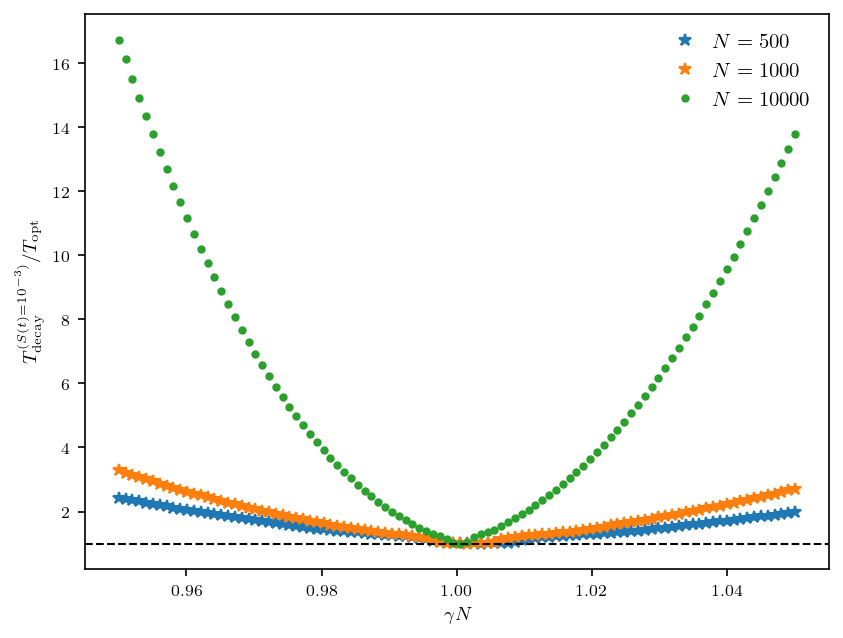

In [396]:
gamma_vals1 = np.linspace(0.95/10000, 1.05/10000, 100)


gamma_vals2 = np.linspace(0.95/1000, 1.05/1000, 100)


gamma_vals3 = np.linspace(0.95/500, 1.05/500, 100)

plt.plot(gamma_vals3*500, T_decay0p001N3/np.min(T_decay0p001N3[T_decay0p001N2>0]),'.',label = f'$N =500 $')
plt.plot(gamma_vals2*1000, T_decay0p001N2/np.min(T_decay0p001N2[T_decay0p001N2>0]),'*',label = f'$N =1000 $')
plt.plot(gamma_vals1*10000, T_decay0p001N1/np.min(T_decay0p001N1[T_decay0p001N1>0]),'^',label = f'$N =10000 $')



plt.axhline(1, ls = '--',color = 'k')
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$T_{\mathrm{decay}}^{(S(t) = 10^{-3})}/T_{\mathrm{opt}}$')

plt.legend(frameon = False)

#plt.savefig(r'prefactor_gammaN_no_resetting.pdf',bbox_inches = 'tight', dpi = 800)

plt.show()

### Fix N, $\gamma = \gamma_{opt}$ compute the $t_{decay}$ to 0.001 (sensitivity of the optimal parameters)

In [410]:
# Parameters
Tcutoff = 10000
dt = 0.05
kappa_vals = np.linspace(0.01, 0.1, 100)
N = 10000  # System size
gamma = 1/N

# Storage Arrays
T_decay0p001N1_k = np.zeros(len(kappa_vals))
s_prob_arr = np.zeros((len(kappa_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, kappa in tqdm(enumerate(kappa_vals), total=len(kappa_vals)):
   # for kk, kappa in enumerate(kappa_vals):      
    s_prob = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
    s_prob_arr[gg] = s_prob
    T_decay0p001N1_k[gg] = find_transition_point(s_prob, dt,0.001)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3341753/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


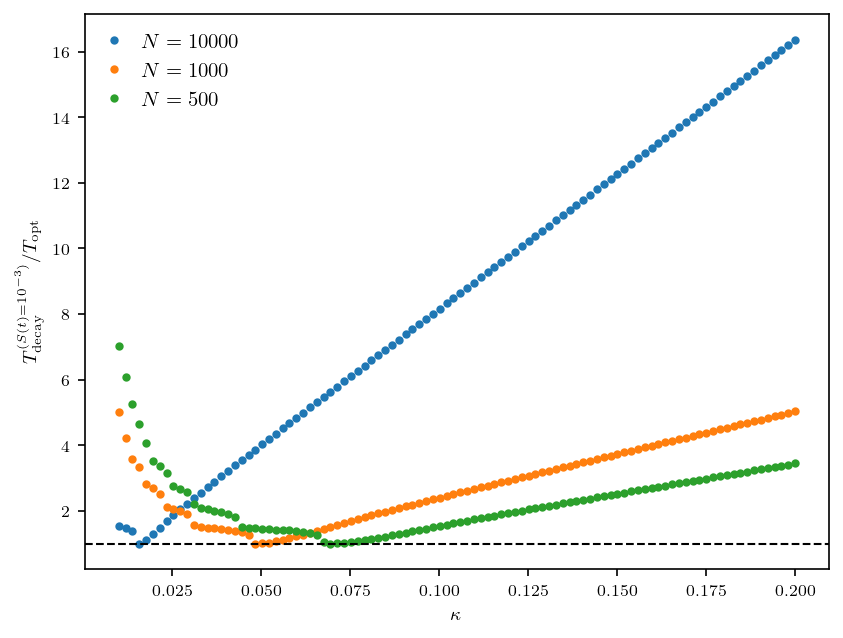

In [411]:
plt.plot(kappa_vals, T_decay0p001N1_k/np.min(T_decay0p001N1_k),'.',label = f'$N =10000 $')
plt.plot(kappa_vals, T_decay0p001N2_k/np.min(T_decay0p001N2_k),'.',label = f'$N =1000$')
plt.plot(kappa_vals, T_decay0p001N3_k/np.min(T_decay0p001N3_k),'.',label = f'$N =500$')


plt.axhline(1, ls = '--',color = 'k')
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$T_{\mathrm{decay}}^{(S(t) = 10^{-3})}/T_{\mathrm{opt}}$')

plt.legend(frameon = False)

#plt.savefig(r'prefactor_kappa_no_resetting.pdf',bbox_inches = 'tight', dpi = 800)

plt.show()

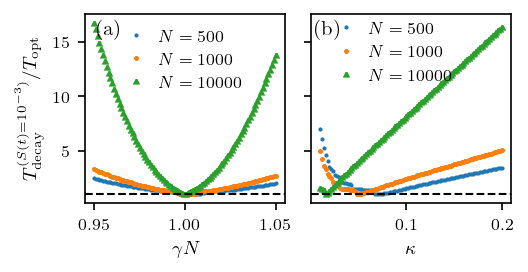

In [433]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(3.40457,0.5*3.40457), constrained_layout=True, sharey=True
)

# --- (a) gammaN scan ---
ax1.plot(gamma_vals3*500, T_decay0p001N3/np.min(T_decay0p001N3),'.',markersize =2,label = f'$N =500 $')
ax1.plot(gamma_vals2*1000, T_decay0p001N2/np.min(T_decay0p001N2[T_decay0p001N2>0]),'*',markersize =2,label = f'$N =1000 $')
ax1.plot(gamma_vals1*10000, T_decay0p001N1/np.min(T_decay0p001N1[T_decay0p001N1>0]),'^',markersize =2,label = f'$N =10000 $')

ax1.axhline(1, ls='--', color='k')
ax1.set_xlabel(r'$\gamma N$')
ax1.set_ylabel(r'$T_{\mathrm{decay}}^{(S(t)=10^{-3})}/T_{\mathrm{opt}}$')
ax1.legend(frameon=False, loc='best',fontsize = 8)
ax1.text(0.06, 0.98, '(a)', transform=ax1.transAxes, ha='left', va='top')

# --- (b) kappa scan ---
ax2.plot(kappa_vals, T_decay0p001N3_k/np.min(T_decay0p001N3_k),'.',markersize =2,label = f'$N =500$')
ax2.plot(kappa_vals, T_decay0p001N2_k/np.min(T_decay0p001N2_k),'*',markersize =2,label = f'$N =1000$')
ax2.plot(kappa_vals, T_decay0p001N1_k/np.min(T_decay0p001N1_k),'^',markersize =2,label = f'$N =10000 $')


ax2.axhline(1, ls='--', color='k')
ax2.set_xlabel(r'$\kappa$')
# y-label shared via sharey=True; omit here to save space
ax2.legend(frameon=False, loc= (0.1,0.6),fontsize = 8)
ax2.text(0.02, 0.98, '(b)', transform=ax2.transAxes, ha='left', va='top')
plt.savefig('supplementary_figure2.pdf', bbox_inches ='tight', transparent = "True", dpi = 600)
plt.show()

## Adaptive Grid size

In [ ]:
# Parameters

kappa_vals = np.linspace(0, 0.4, 100)
NList =  np.floor(np.logspace(2,5,50)) # System size


for N in tqdm(NList):

    Tcutoff = 2*np.sqrt(N) # cutoff time increasing with square root of N
    dt = 0.05


    gamma_vals = np.linspace(0.9/N, 1.1/N, 100)
    
    # Storage Arrays
    T_decay0p5_theory = np.zeros((len(gamma_vals), len(kappa_vals)))
    s_prob_arr_theory = np.zeros((len(gamma_vals), len(kappa_vals), int(Tcutoff / dt)))
    
    # Compute Survival Probabilities and Transition Points
    for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
        for kk, kappa in enumerate(kappa_vals):
            for rr, r in enumerate(r_vals):
                s_prob_theory = surv_prob_theory_total(Tcutoff, dt, r, N, gamma, w, kappa)
                s_prob_arr_theory[gg, kk, rr] = s_prob_theory
                T_decay0p5_theory[gg, kk, rr] = find_transition_point(s_prob_theory, dt)
    
    filename = f"Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_NO_SPROB_theory.pkl"
    dict_to_save = [gamma_vals, kappa_vals, r_vals, T_decay0p5_theory]
    with open(filename, 'wb') as f:
        pickle.dump(dict_to_save, f)

## Visualizations

In [133]:
# Parameters
NList =  np.floor(np.logspace(2,5,50))# System size


runtimes = np.zeros(len(NList))
gammaN_opts = np.zeros(len(NList))
kappa_opts = np.zeros(len(NList))

for j, N in enumerate(NList):

    Tcutoff = 2*np.sqrt(N)
    dt = 0.05

    filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_NO_SPROB_theory.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    gamma_vals, kappa_vals, r_vals, T_decay0p5_theory = data

    T_min_theory = np.zeros((len(gamma_vals), len(kappa_vals)))
    T_decay0p5_theory = np.where(T_decay0p5_theory==0, np.inf, T_decay0p5_theory)

    for gg in tqdm(range(len(gamma_vals))):
        for kk in range(len(kappa_vals)):
            T_decay_temp = T_decay0p5_theory[gg, kk]
            if len(T_decay_temp) > 0:
                T_min_theory[gg, kk] = np.min(T_decay_temp)
                #r_optimal[gg, kk] = r_vals[np.argmin(T_decay_temp)]
            else:
                T_min_theory[gg, kk] = np.nan  # Mark undefined cases
                #r_optimal[gg, kk] = np.nan

    id = np.unravel_index(T_min_theory.argmin(), T_min_theory.shape)
    runtimes[j] = T_min_theory[np.unravel_index(T_min_theory.argmin(), T_min_theory.shape)]
    gammaN_opts[j] = gamma_vals[id[0]]
    kappa_opts[j] = kappa_vals[id[1]]

100%|██████████| 100/100 [00:00<00:00, 6798.12it/s]


In [134]:
def timeScaling(Nlist):
    return [np.sqrt(N) for N in Nlist]

data = timeScaling(NList)

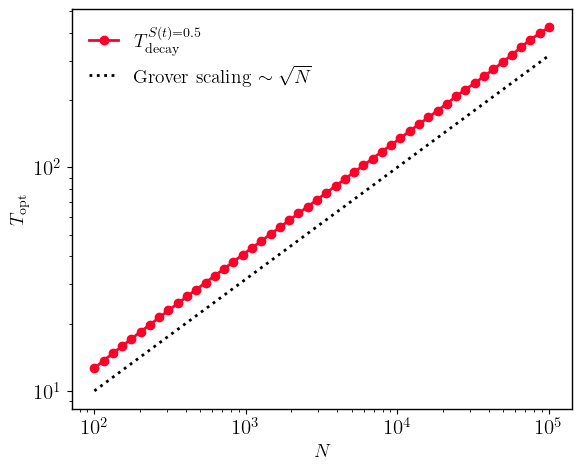

In [137]:
fig = plt.figure(figsize=(5,4)) #Generate figure with a given size
ax = fig.add_axes([0, 0, 1, 1]) #Add axes object to our figure that takes up entire figure

colors = plt.get_cmap('gist_rainbow', 16)
plt.plot(NList, runtimes, color=colors(0), marker='o', linestyle='-', label=r"$T_{\mathrm{decay}}^{S(t) = 0.5}$")
plt.plot(NList, np.array(data), color="k", ls=":", label=r"Grover scaling $\sim \sqrt{N}$")
plt.xlabel(r"$N$",size = 14) #x-axis label
plt.ylabel(r"$T_{\mathrm{opt}}$", size = 14) #y-axis label
plt.legend(fontsize = 14)
#plt.legend(loc= 0, prop={'size': 12}, labelspacing=0.01, frameon=False)
plt.yscale('log')
plt.xscale('log')
#filename = f"Overlaps_figure_N{N}_dim{d}_alpha{alpha_str}.pdf"

#plt.tight_layout()
#plt.savefig("../Figures/Final/CompleteGraphTopt.pdf", dpi=800, transparent=True, bbox_inches='tight')

#plt.savefig('scaling.pdf',bbox_inches = 'tight')
plt.show()

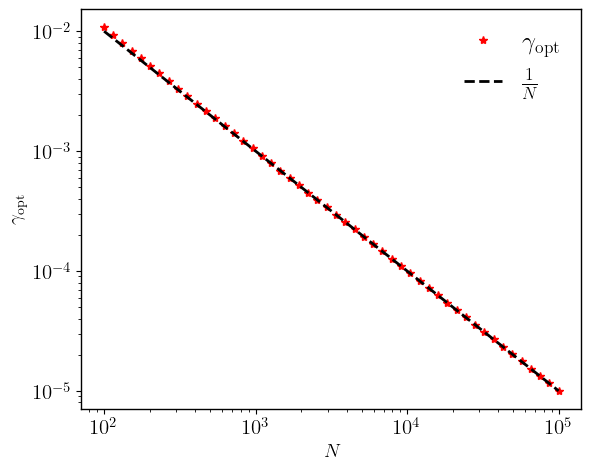

In [146]:
fig = plt.figure(figsize=(5,4))  # Same size as the first plot
ax1 = fig.add_axes([0, 0, 1, 1])  # Primary axis

# Energy curves on the primary y-axis
ax1.plot(NList, gammaN_opts,'*', label=r"$\gamma_{\rm opt}$", color="red")

# Primary axis settings
ax1.set_xlabel(r"$N$", size =14)
#plt.title(r"Optimal parameter values", color="black")
ax1.set_ylabel(r"$\gamma_{\rm opt}$", color="k", size = 14)
#ax1.tick_params(axis="both", direction="in", labelcolor="black")
#ax1.spines["left"].set_color("red")
#ax1.spines["left"].set_linewidth(1.5)
ax1.plot(NList,1/NList,'--', label=r"$~\frac{1}{N}$", color="k")

ax1.set_xscale('log')
ax1.set_yscale('log')

# Add a secondary y-axis for purity
#ax2 = ax1.twinx()
#ax2.plot(NList, kappa_opts,'o', label=r"$\kappa_{\rm opt}$", color="blue")
#ax2.set_ylabel(r"$\kappa_{\rm opt}$", color="blue", size = 14)
#ax2.tick_params(axis="y", direction="in", labelcolor="blue")
#ax2.spines["right"].set_color("blue")
#ax2.spines["right"].set_linewidth(1.5)
#ax2.plot(NList,1.4/np.sqrt(NList),'--', label=r"$~\frac{1}{\sqrt{N}}$", color="blue")


#ax2.set_xscale('log')
#ax2.set_yscale('log')


# Combined legend
lns1, labels1 = ax1.get_legend_handles_labels()
#lns2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lns1 + lns2, labels1 + labels2, loc="upper right", prop={'size': 12}, labelspacing=0.01, frameon=False)

ax1.legend()

#plt.tight_layout()

#plt.savefig("gamma_kappa_opt.pdf", dpi=800, transparent=True, bbox_inches='tight')


plt.show()

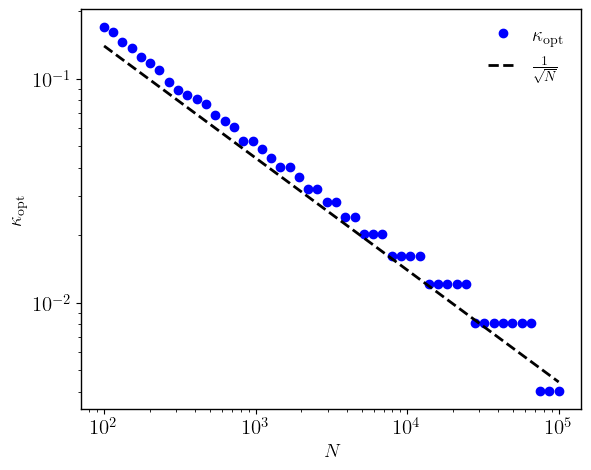

In [147]:
fig = plt.figure(figsize=(5,4))  # Same size as the first plot
ax1 = fig.add_axes([0, 0, 1, 1])  # Primary axis

# Energy curves on the primary y-axis
#ax1.plot(NList, gammaN_opts,'*', label=r"$\gamma_{\rm opt}$", color="red")

# Primary axis settings
#ax1.set_xlabel(r"$N$", size =14)
#plt.title(r"Optimal parameter values", color="black")
#ax1.set_ylabel(r"$\gamma_{\rm opt}$", color="k", size = 14)
#ax1.tick_params(axis="both", direction="in", labelcolor="black")
#ax1.spines["left"].set_color("red")
#ax1.spines["left"].set_linewidth(1.5)
#ax1.plot(NList,1/NList,'--', label=r"$~\frac{1}{N}$", color="k")

#ax1.set_xscale('log')
#ax1.set_yscale('log')

# Add a secondary y-axis for purity
#ax2 = ax1.twinx()
ax1.plot(NList, kappa_opts,'o', label=r"$\kappa_{\rm opt}$", color="blue")
ax1.set_ylabel(r"$\kappa_{\rm opt}$", color="k", size = 14)
#ax1.tick_params(axis="y", direction="in", labelcolor="k")
#ax2.spines["right"].set_color("blue")
#ax2.spines["right"].set_linewidth(1.5)
ax1.plot(NList,1.4/np.sqrt(NList),'--', label=r"$~\frac{1}{\sqrt{N}}$", color="k")
ax1.set_xlabel(r"$N$", size =14)

ax1.set_xscale('log')
ax1.set_yscale('log')


# Combined legend
lns1, labels1 = ax1.get_legend_handles_labels()
#lns2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lns1 + lns2, labels1 + labels2, loc="upper right", prop={'size': 12}, labelspacing=0.01, frameon=False)

ax1.legend(fontsize = 14)

#plt.tight_layout()

#plt.savefig("gamma_kappa_opt.pdf", dpi=800, transparent=True, bbox_inches='tight')


plt.show()

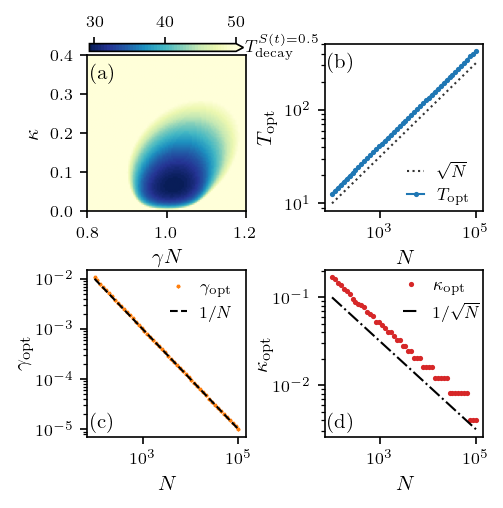

In [310]:
from matplotlib.ticker import LogLocator, NullFormatter

# ---------- Data need to be defined ----------
# T_decay0p5_theory_single : shape (len(kappa_vals), len(gamma_vals))
# kappa_vals, gamma_vals, N
# NList, runtimes, data
# gammaN_opts, kappa_opts

# axis for panel (a)
N = 500
gamma_vals = np.linspace(0.8/N, 1.2/N, 100)
gammaN_axis = gamma_vals * N

# ---------- Figure layout----------

fig = plt.figure(figsize=(3.40457,3.40457 ))
#gs = fig.add_gridspec(2, 2, wspace=0.5, hspace=0.35)

# ---------- (a) Heatmap: minimum search time ----------
ax_a = fig.add_subplot(gs[0, 0])
im = ax_a.imshow(
    T_decay0p5_theory_single.T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],
    cmap=plt.get_cmap("YlGnBu_r", 50), vmax=50
)
ax_a.set_xlabel(r"$\gamma N$",fontsize = 10)
ax_a.set_ylabel(r"$\kappa$",fontsize = 10)
cbar = fig.colorbar(im, ax=ax_a, extend="max", pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, -1, r"$T_{\rm decay}^{S(t)=0.5}$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

# ---------- (b) Scaling: T_opt vs N ----------
ax_b = fig.add_subplot(gs[0, 1])
ax_b.plot(NList, np.array(data), color="0.2", linestyle=":",
          label=r"$ \sqrt{N}$")
ax_b.plot(NList, runtimes, marker="o", linestyle="-", markersize = 1.5 ,lw = 1,
          label=r"$T_{\mathrm{opt}}$" )

ax_b.set_xscale("log")
ax_b.set_yscale("log")
ax_b.set_xlabel(r"$N$",fontsize = 10)
ax_b.set_ylabel(r"$T_{\mathrm{opt}}$",fontsize = 10)
ax_b.legend(frameon=False,loc= (0.48,0),fontsize = 8)
# nicer log ticks
ax_b.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_b.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_b.yaxis.set_minor_formatter(NullFormatter())
ax_b.text(0.02,0.95 , "(b)", transform=ax_b.transAxes,va="top", ha="left",fontsize =10)

# ---------- (c) gamma_opt vs N ----------
ax_c = fig.add_subplot(gs[1, 0])
ax_c.plot(NList, gammaN_opts, "*", markersize = 1.5, label=r"$\gamma_{\rm opt}$", color="C1")
ax_c.plot(NList, 1/np.array(NList), "--", color="k", label=r"$1/N$")
ax_c.set_xscale("log")
ax_c.set_yscale("log")
ax_c.set_xlabel(r"$N$",fontsize = 10)
ax_c.set_ylabel(r"$\gamma_{\rm opt}$",fontsize = 10,labelpad=1)
ax_c.legend(frameon=False, loc= (0.48,0.65),fontsize =8)
ax_c.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_c.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_c.yaxis.set_minor_formatter(NullFormatter())
ax_c.text(0.02,0.15, "(c)", transform=ax_c.transAxes,va="top", ha="left",fontsize =10)

# ---------- (d) kappa_opt vs N ----------
ax_d = fig.add_subplot(gs[1, 1])
ax_d.plot(NList, kappa_opts, "o",markersize = 1.5, label=r"$\kappa_{\rm opt}$", color="C3")
ax_d.plot(NList, 1/np.sqrt(np.array(NList)), "-.", color="k",
          label=r"$ 1/\sqrt{N}$")
ax_d.set_xscale("log")
ax_d.set_yscale("log")
ax_d.set_xlabel(r"$N$",fontsize = 10)
ax_d.set_ylabel(r"$\kappa_{\rm opt}$",fontsize = 10,labelpad=0)
ax_d.legend(frameon=False, loc= (0.45,0.65), fontsize = 8 )
ax_d.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_d.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_d.yaxis.set_minor_formatter(NullFormatter())
ax_d.text(0.02,0.15 , "(d)", transform=ax_d.transAxes,va="top", ha="left",fontsize =10)

# ---------- Tight layout & save ----------
#fig.tight_layout()
plt.savefig("Figure1.pdf", bbox_inches="tight", transparent=True)
plt.show()
